In [112]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import lognorm

#colors I like
f3_green = '#75ba3f'
f3_blue = '#232c3b'

# Description 

This Python code simulates the ordering behavior in an online store. It generates a catalog of available products, creates a list of customers, and then simulates the placement of orders by each customer. The number of orders made by each customer and the size of each order are random variables determined using lognormal distributions, introducing variability in customer behavior. Each order draws a random sample from the list of items. Additionally, the code allows for the creation of a random combination of items and checks which customers have placed orders containing at least one item from this fixed set. 

In the section "Simulation", we simulate an experiment where we want to test if some change made to a specific set of items may influence the purchasing behavior of customers, with focus on the average basket size, which will be referred to as _units per order_ (UPO). We investigate the impact of a specific set of items, referred to as the `fixed_set`, on the average order size of customers in two different periods, which by convenience we call pre-treatment and post-treatment. The simulation is conducted over multiple iterations, and at each iteration we randomly generate a new `fixed_set`. We select customers as follows: during the post-treatment period, customers who have placed an order containing at least one item from the `fixed_set` are sampled. The UPO for these sampled customers is compared between the post and pre periods. We show that there is an increase in UPO post-treatment compared to UPO pre-treatment which is due to sampling bias, as the focus is specifically on customers engaging with the fixed_set in the post-period. 

We demonstrate that with this procedure, we consistently obtain larger baskets for those specific customer in the "post" period vs the same in the "pre" period. This is due to <mark style="background-color: orange">selection bias</mark>: there is selection bias while sampling orders conditioned on the presence of specific items, which then propagates in the sampling of customers.

# Functions

In [60]:
import numpy as np

def generate_catalogue(n_items):
    """
    Generate a catalogue of all available products.

    Parameters:
    - n_items (int): Number of available products.

    Returns:
    - item_list (list): List of available products labeled with integer numbers.
    """
    item_list = list(range(1, n_items + 1))
    return item_list

def generate_customers(n_customers):
    """
    Generate a list of all customers labeled with integer numbers.

    Parameters:
    - n_customers (int): Number of customers.

    Returns:
    - customer_list (list): List of all customers labeled with integer numbers.
    """
    customer_list = list(range(1, n_customers + 1))
    return customer_list

def generate_order(item_list, order_size_mean, order_size_sigma):
    """
    Generate an order by randomly sampling items from the item list.

    Parameters:
    - item_list (list): List of available products.
    - order_size_mean (float): Mean of the lognormal distribution for order sizes.

    Returns:
    - order (list): List of items in the order.
    """
    max_order_size = len(item_list)
    order_size = max_order_size+1
    while order_size>max_order_size:
        order_size = np.random.lognormal(mean=order_size_mean, sigma=order_size_sigma)
    order_size = max(1, int(order_size))
    order = np.random.choice(item_list, size=order_size, replace=False)
    return order

def generate_random_orders(customer_list, item_list, orders_per_customer_mean, 
                           orders_per_customer_sigma, order_size_mean, order_size_sigma):
    """
    Generate random orders for each customer.

    Parameters:
    - customer_list (list): List of customers.
    - item_list (list): List of available products.
    - orders_per_customer_mean (float): Mean of the lognormal distribution for orders per customer.
    - order_size_mean (float): Mean of the lognormal distribution for order sizes.

    Returns:
    - orders_dict (dict): Dictionary mapping customer IDs to their respective orders.
    """
    orders_dict = {}
    for customer_id in customer_list:
        num_orders = max(1, int(np.random.lognormal(mean=orders_per_customer_mean, sigma=orders_per_customer_sigma)))
        orders = [generate_order(item_list, order_size_mean, order_size_sigma) for _ in range(num_orders)]
        orders_dict[customer_id] = orders
    return orders_dict

def generate_random_combination(item_list, number_of_items):
    """
    Generate a random combination of items from item_list.

    Parameters:
    - item_list (list): List of available products.
    - number_of_items (int): Number of items in the random combination.

    Returns:
    - random_combination (numpy array): 1D array containing the random combination of items.
    """
    random_combination = np.random.choice(item_list, size=number_of_items, replace=False)
    return random_combination

def order_contains_random_items(order, random_combination):
    """
    Check if an order contains at least one item from a random combination.

    Parameters:
    - order (numpy array): 1D array representing the order.
    - random_combination (numpy array): 1D array representing the random combination.

    Returns:
    - contains_random_items (bool): True if the order contains at least one item from the random combination, False otherwise.
    """
    contains_random_items = np.any(np.isin(order, random_combination))
    return contains_random_items


def customers_with_orders_with_items_in_fixed_set(customer_orders, fixed_set):
    """
    Identify customers with at least one order containing an item from a combination of items.

    Parameters:
    - customer_orders (list): List of customer orders. Each element is a list of numpy arrays.
    - fixed_set (numpy array): 1D array representing an item combination.

    Returns:
    - customers_with_items (list): List of customer IDs with at least one order containing an item from a fixed item combination.
    """
    customers_with_items = []
    for customer_id, orders in customer_orders.items():
        for order in orders:
            if order_contains_random_items(order, fixed_set):
                customers_with_items.append(customer_id)
                break  # Exit the inner loop once a match is found for this customer
    return customers_with_items

def get_orders_lengths(customer_orders, customer_id_list=None):
    """
    Flatten the list of customer orders into a numpy array with order lengths.

    Parameters:
    - customer_orders (dict): Dictionary mapping customer IDs to their respective orders.
    - customer_id_list (list): List with customer IDs to consider. If None, all customers are considered
    Returns:
    - order_lengths (numpy array): 1D array containing the lengths of all orders of all customers.
    """
    if customer_id_list is None:
        customer_id_list = customer_orders.keys()
    orders_lengths=[]
    for customer in customer_id_list:
        for order in customer_orders[customer]:
            orders_lengths.append(len(order))
    return orders_lengths

def get_mean_order_length(customer_orders, customer_id_list=None):
    if customer_id_list is None:
        customer_id_list = customer_orders.keys()
    orders_lengths=[]
    for customer in customer_id_list:
        for order in customer_orders[customer]:
            orders_lengths.append(len(order))
    mean_length = np.array(orders_lengths).mean()
    return mean_length

def count_orders_per_customer(customer_orders):
    """
    Count the number of orders made by each customer.

    Parameters:
    - customer_orders (dict): Dictionary mapping customer IDs to their respective orders.

    Returns:
    - orders_per_customer (list): List containing the number of orders for each customer.
    """
    orders_per_customer = [len(orders) for orders in customer_orders.values()]
    return orders_per_customer

# Data generation

In [50]:
n_items = 100
n_customers = 500
item_set_size = 10
orders_per_customer_mean = 2
orders_per_customer_sigma = 1
order_size_mean = 2
order_size_sigma = 0.9

item_list = generate_catalogue(n_items)
customer_list = generate_customers(n_customers)
customer_orders = generate_random_orders(customer_list, item_list, orders_per_customer_mean, 
                           orders_per_customer_sigma,order_size_mean, order_size_sigma)

type(customer_orders), type(customer_orders[1]), type(customer_orders[1][0]) 

(dict, list, numpy.ndarray)

In [51]:
# some analyses
all_order_sizes = get_orders_lengths(customer_orders)
tot_n_order = len(all_order_sizes)
print(np.array(all_order_sizes).mean())
print(tot_n_order)

10.356031453906642
5977


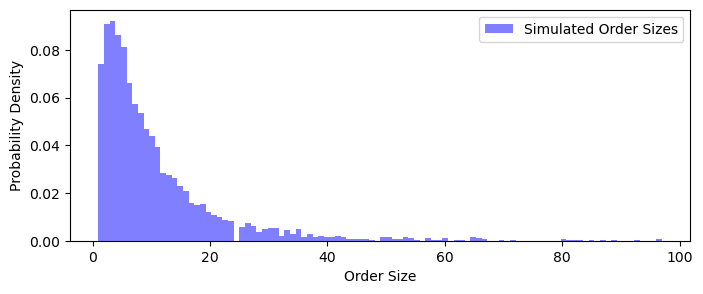

In [52]:
plt.figure(figsize=(8,3))
plt.hist(all_order_sizes, bins=100, density=True, alpha=0.5, color='blue', label='Simulated Order Sizes')

# Fit a lognormal distribution to the simulated data
shape, loc, scale = lognorm.fit(all_order_sizes)
x = np.linspace(0, max(all_order_sizes), 100)
pdf = lognorm.pdf(x, shape, loc=loc, scale=scale)

#plt.plot(x, pdf, 'r-', label='Fitted Lognormal Distribution')
#plt.yscale('log')
plt.xlabel('Order Size')
plt.ylabel('Probability Density')
plt.legend()
plt.show()

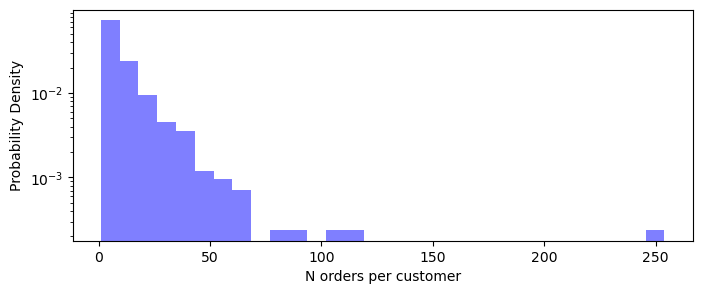

In [55]:
n_orders_per_customer = count_orders_per_customer(customer_orders)

plt.figure(figsize=(8,3))
plt.hist(n_orders_per_customer, bins=30, density=True, alpha=0.5, color='blue')
plt.yscale('log')
plt.xlabel('N orders per customer')
plt.ylabel('Probability Density')
plt.show()

# Simulation

In [95]:
n_iterations = 1000
n_items = 200
n_customers = 1000
item_set_size = 10
orders_per_customer_mean = 2
orders_per_customer_sigma = 1
order_size_mean = 2
order_size_sigma = 0.9


item_list = generate_catalogue(n_items)
customer_list = generate_customers(n_customers)

customer_orders_pre = generate_random_orders(customer_list, item_list, orders_per_customer_mean, 
                           orders_per_customer_sigma,order_size_mean, order_size_sigma)
customer_orders_post = generate_random_orders(customer_list, item_list, orders_per_customer_mean, 
                           orders_per_customer_sigma,order_size_mean, order_size_sigma)

mean_order_size_post_l = []
mean_order_size_pre_l = []
# iterations
for i in range(n_iterations):
    #generating a random basket to match orders/clients to
    fixed_set = generate_random_combination(item_list, item_set_size)
    cid_treatment_list = customers_with_orders_with_items_in_fixed_set(customer_orders_post, fixed_set)
    mean_order_size_post = get_mean_order_length(customer_orders_post, cid_treatment_list)
    mean_order_size_pre  = get_mean_order_length(customer_orders_pre,  cid_treatment_list)
    mean_order_size_post_l.append(mean_order_size_post)
    mean_order_size_pre_l.append(mean_order_size_pre)

The following figure demonstrates the presence of <mark style="background-color: orange"> selection bias</mark>:

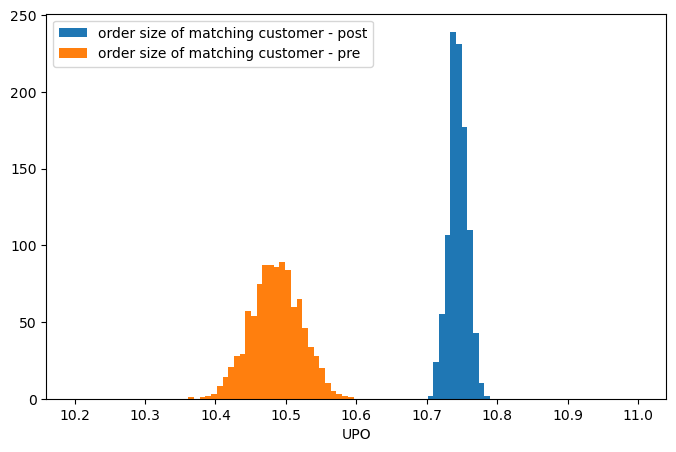

In [100]:
bins=30
bins = np.linspace(10.2, 11, 100)
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
ax.hist(mean_order_size_post_l, bins=bins, label='order size of matching customer - post')
ax.hist(mean_order_size_pre_l, bins=bins, label='order size of matching customer - pre')
ax.set(xlabel='UPO'), plt.legend()
plt.show()

# Backup

## plotting distributions

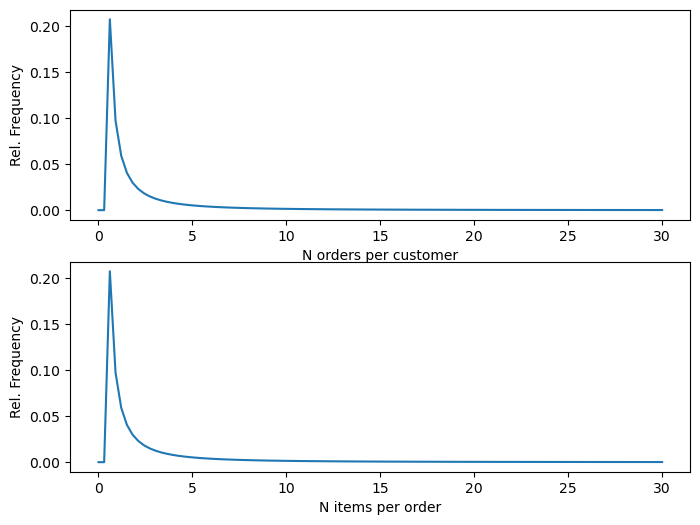

In [73]:
x_orders = np.linspace(0, 30, 100)  
y_orders = lognorm.pdf(x, orders_per_customer_mean, orders_per_customer_sigma)  
x_size = np.linspace(0, 30, 100)  
y_size = lognorm.pdf(x, orders_per_customer_mean, orders_per_customer_sigma)  

fig, ax = plt.subplots(2,1,figsize=(8,6))
ax[0].plot(x_orders, y_orders)
ax[0].set(xlabel='N orders per customer', ylabel='Rel. Frequency')
ax[1].plot(x_size, y_size)
ax[1].set(xlabel='N items per order', ylabel='Rel. Frequency')

plt.show()

## No customers
Here we drop customers from the analysis, and limit ourselves to simulate orders, fix a set of items, and show that the UPO of orders matching at least one of the items in the set is larger than the overall UPO

In [2]:
def generate_baskets(n_items, n_orders):
    # Generate random basket sizes from a lognormal distribution
    basket_sizes = np.random.lognormal(mean=2, sigma=1, size=n_orders).astype(int)

    # Ensure that basket sizes are within the range of available items
    basket_sizes = np.clip(basket_sizes, 1, n_items)

    # Generate baskets for each order
    baskets = [np.random.choice(range(1, n_items + 1), size=size, replace=False) for size in basket_sizes]

    return baskets

In [3]:
# Simulation parameters
n_items = 100 #1000
n_orders = 1000 #500
# Add a parameter for item_set_size
item_set_size = 10

In [3]:
# Run simulation
simulated_baskets = generate_baskets(n_items, n_orders)

# Example: Display the first 5 simulated baskets
for i in range(5):
    print(f"Order {i + 1} - Basket: {simulated_baskets[i]}")

Order 1 - Basket: [80 49  4 17 64 57 13 59]
Order 2 - Basket: [13 59 90 87 30 88 83 81 15 10 73 51 95]
Order 3 - Basket: [78 40 59 24 84 81 92 44 82 21 42 74 18]
Order 4 - Basket: [44 49 22 21 98 55 82 86]
Order 5 - Basket: [28 51 10 56 21 92 95 71 43 88 97]


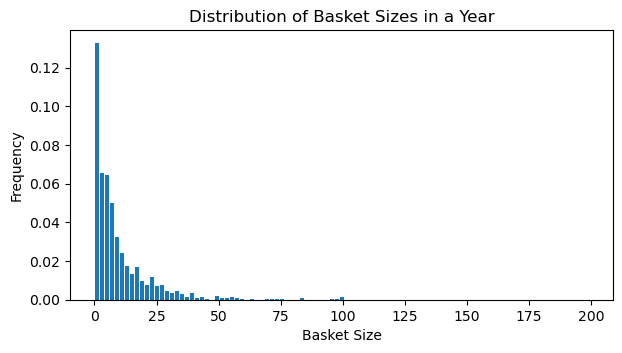

In [4]:
# Plot histogram of basket sizes

bins= np.linspace(1, n_items + 2,100)
bins= np.linspace(1, 200,100)

fig, ax = plt.subplots(1,1,figsize=(7,3.5))
ax.hist([len(basket) for basket in simulated_baskets], bins=bins, align='left', rwidth=0.8, density=True)
#ax.set_yscale('log')
ax.set(xlabel='Basket Size', ylabel='Frequency', 
       title='Distribution of Basket Sizes in a Year')
plt.show()

In [5]:
# Calculate and print the average order size
average_order_size = np.mean([len(basket) for basket in simulated_baskets])
print(f"Average Order Size: {average_order_size:.2f}")


Average Order Size: 11.29


In [6]:
# Randomly select a set of items of size item_set_size
random_item_set = np.random.choice(range(1, n_items + 1), size=item_set_size, replace=False)

# Filter baskets to include only those containing at least one item from the random set
baskets_with_random_item_set = [basket for basket in simulated_baskets if any(item in random_item_set for item in basket)]

# Calculate and print the average size of orders containing at least one item from the random set
average_size_with_random_item_set = np.mean([len(basket) for basket in baskets_with_random_item_set])
print(f"Average Order Size with at least one item from the random set: {average_size_with_random_item_set:.2f}")


Average Order Size with at least one item from the random set: 16.85


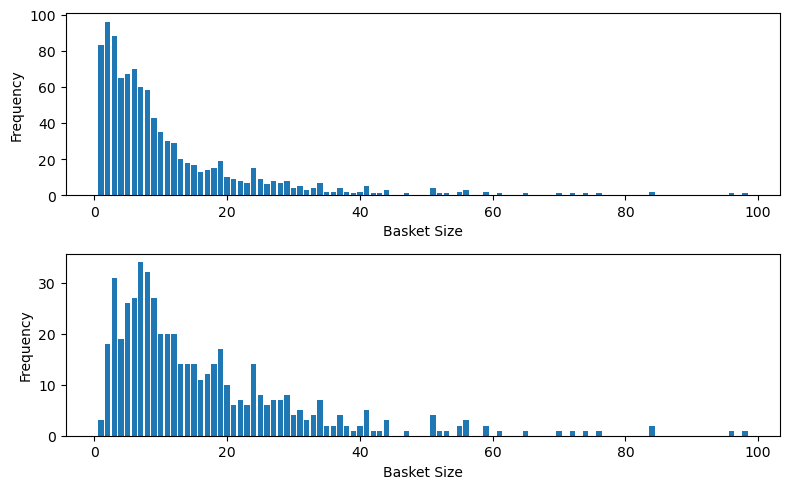

In [7]:
# Create subplots with two panels
fig, axes = plt.subplots(2, 1, figsize=(8, 5))

# Panel 1: Distribution of all basket sizes
axes[0].hist([len(basket) for basket in simulated_baskets], bins=range(1, 100), align='left', rwidth=0.8)
#axes[0].set_xscale('log')
axes[0].set_xlabel('Basket Size')
axes[0].set_ylabel('Frequency')

# Panel 2: Distribution of basket sizes for the random_item_set
axes[1].hist([len(basket) for basket in baskets_with_random_item_set], bins=range(1, 100), align='left', rwidth=0.8)
#axes[1].set_xscale('log')
axes[1].set_xlabel('Basket Size')
axes[1].set_ylabel('Frequency')

# Adjust layout to prevent overlapping
plt.tight_layout()

# Show the plots
plt.show()

what you're observing is a form of the inspection paradox. The inspection paradox refers to the phenomenon where an average or expectation calculated from a subset of a population may differ significantly from the average or expectation calculated from the entire population.

In your case, when you look only at orders containing at least one item from the specific random_item_set, you are essentially sampling a subset of the population of all orders. This subset may have a higher average size compared to the average size of all orders. The inspection paradox arises because larger orders are more likely to contain items from the specified set, leading to an inflated average size when considering only those orders.

It's a common occurrence in various scenarios, such as when analyzing disease prevalence in a specific demographic group or studying the average income of customers who purchased a particular product. The subset you're examining is not a random sample, and the act of observing or conditioning on a specific characteristic can bias the results.







Now repeat that process N times, N=1000. Every iteration, consider a new random_item_set.

## simulation
We can modify the code to run multiple iterations (N_iter) of the yearly basket simulation and then calculate the average basket size for all baskets and the baskets containing at least one item from the random set. Finally, we'll plot a histogram of the two averages. Here's the code:



In [102]:
import numpy as np
import matplotlib.pyplot as plt

def generate_baskets(n_items, n_orders):
    basket_sizes = np.random.lognormal(mean=2, sigma=1, size=n_orders).astype(int)
    basket_sizes = np.clip(basket_sizes, 1, n_items)
    baskets = [np.random.choice(range(1, n_items + 1), size=size, replace=False) for size in basket_sizes]
    return baskets

# Simulation parameters
N_iter = 1000  # Number of iterations
n_orders=500
# Results storage
all_basket_sizes = []
random_item_set_basket_sizes = []

# Run N_iter simulations
for _ in range(N_iter):
    # Generate baskets for the current iteration
    simulated_baskets = generate_baskets(n_items, n_orders)

    # Calculate average basket size for all baskets
    all_basket_sizes.append(np.mean([len(basket) for basket in simulated_baskets]))

    # Randomly select a set of items of size item_set_size
    random_item_set = np.random.choice(range(1, n_items + 1), size=item_set_size, replace=False)

    # Filter baskets to include only those containing at least one item from the random set
    baskets_with_random_item_set = [basket for basket in simulated_baskets if any(item in random_item_set for item in basket)]

    # Calculate average basket size for baskets with at least one item from the random set
    random_item_set_basket_sizes.append(np.mean([len(basket) for basket in baskets_with_random_item_set]))

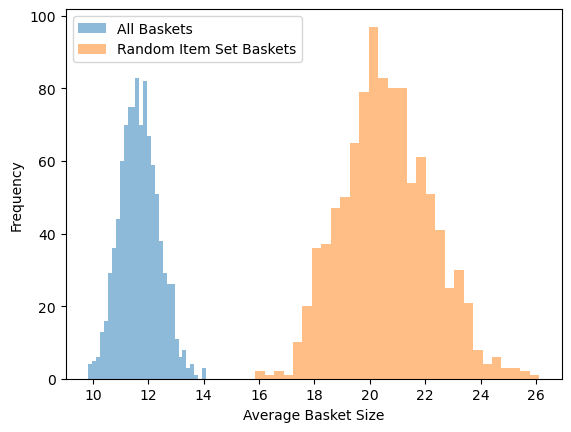

In [103]:
# Plot histogram of average basket sizes
plt.hist(all_basket_sizes, bins=30, alpha=0.5, label='All Baskets')
plt.hist(random_item_set_basket_sizes, bins=30, alpha=0.5, label='Random Item Set Baskets')
plt.xlabel('Average Basket Size')
plt.ylabel('Frequency')
plt.legend()
#plt.title(f'Distribution of Average Basket Sizes over {N_iter} Iterations')
plt.show()

fixed basket

In [108]:
import numpy as np
import matplotlib.pyplot as plt

def generate_baskets(n_items, n_orders):
    basket_sizes = np.random.lognormal(mean=2, sigma=1, size=n_orders).astype(int)
    basket_sizes = np.clip(basket_sizes, 1, n_items)
    baskets = [np.random.choice(range(1, n_items + 1), size=size, replace=False) for size in basket_sizes]
    return baskets

N_iter = 1000  # Number of iterations
n_orders=500
n_items=100

# Results storage
all_basket_sizes = []
random_item_set_basket_sizes = []

# Generate baskets
simulated_baskets = generate_baskets(n_items, n_orders)
simulated_baskets_mean = np.mean([len(basket) for basket in simulated_baskets])
# Run N_iter simulations
for _ in range(N_iter):
    # Calculate average basket size for all baskets
    all_basket_sizes.append(np.mean([len(basket) for basket in simulated_baskets]))

    # Randomly select a set of items of size item_set_size
    random_item_set = np.random.choice(range(1, n_items + 1), size=item_set_size, replace=False)

    # Filter baskets to include only those containing at least one item from the random set
    baskets_with_random_item_set = [basket for basket in simulated_baskets if any(item in random_item_set for item in basket)]

    # Calculate average basket size for baskets with at least one item from the random set
    random_item_set_basket_sizes.append(np.mean([len(basket) for basket in baskets_with_random_item_set]))

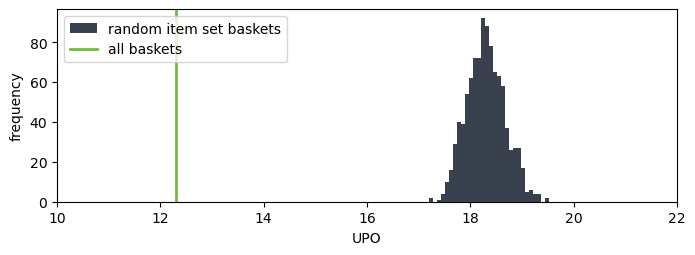

In [111]:
# Plot histogram of average basket sizes
fig, ax = plt.subplots(1,1,figsize=(8,2.5))
ax.hist(random_item_set_basket_sizes, bins=30, alpha=0.9, color='#232c3b', label='random item set baskets')
ax.axvline(x=simulated_baskets_mean, color=f3_green, linestyle='solid', linewidth=2, label='all baskets')  # Add this line
ax.set(xlabel='UPO', ylabel='frequency', xlim=(10,22))
plt.legend()
#plt.title(f'Distribution of Average Basket Sizes over {N_iter} Iterations')
plt.show()